In [90]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score, classification_report, precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyClassifier

import seaborn as sns
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

import plotly.io as pio

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [2]:
coins = ['bitcoin', 'ethereum', 'cardano']

In [3]:
bitcoin = pd.read_csv('../data/external/bitcoin.csv', parse_dates=['Date'])
cardano = pd.read_csv('../data/external/cardano.csv', parse_dates=['Date'])
ethereum = pd.read_csv('../data/external/ethereum.csv', parse_dates=['Date'])

df = pd.concat([bitcoin, cardano, ethereum], axis=0)

In [4]:
df.shape

(6525, 10)

In [5]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [6]:
df.value_counts(['Symbol'])

Symbol
BTC       2991
ETH       2160
ADA       1374
dtype: int64

In [7]:
df.dtypes

SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

## Data Exploration

### Bitcoin

In [8]:
print(
    f"Min Date: {df[df.Symbol == 'BTC'].Date.min()}, Max Date: {df[df.Symbol == 'BTC'].Date.max()}"
)


Min Date: 2013-04-29 23:59:59, Max Date: 2021-07-06 23:59:59


In [9]:
df[df.Symbol == 'BTC'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


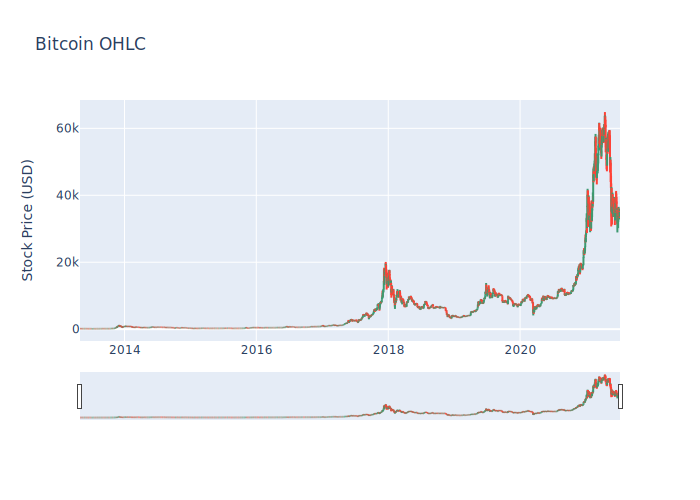

In [10]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'BTC']['Date'],
                             open=df[df.Symbol == 'BTC']['Open'],
                             high=df[df.Symbol == 'BTC']['High'],
                             low=df[df.Symbol == 'BTC']['Low'],
                             close=df[df.Symbol == 'BTC']['Close']))
fig.update_layout(title='Bitcoin OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

## Cardano

In [11]:
print(
    f"Min Date: {df[df.Symbol == 'ADA'].Date.min()}, Max Date: {df[df.Symbol == 'ADA'].Date.max()}"
)


Min Date: 2017-10-02 23:59:59, Max Date: 2021-07-06 23:59:59


In [12]:
df[df.Symbol == 'ADA'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1.374000e+03,1.374000e+03
mean,687.500000,0.269807,0.239710,0.255287,0.256313,8.934183e+08,7.603454e+09
std,396.783946,0.433523,0.380928,0.408456,0.409691,2.107653e+09,1.303878e+10
min,1.000000,0.021050,0.017620,0.018414,0.018539,1.739460e+06,4.806646e+08
25%,344.250000,0.047565,0.044601,0.045898,0.045947,5.014830e+07,1.191263e+09
50%,687.500000,0.090274,0.083164,0.086867,0.087002,1.186742e+08,2.270889e+09
75%,1030.750000,0.194519,0.172442,0.181374,0.183379,4.875977e+08,5.174547e+09
max,1374.000000,2.461766,2.013285,2.300190,2.309113,1.914198e+10,7.377224e+10


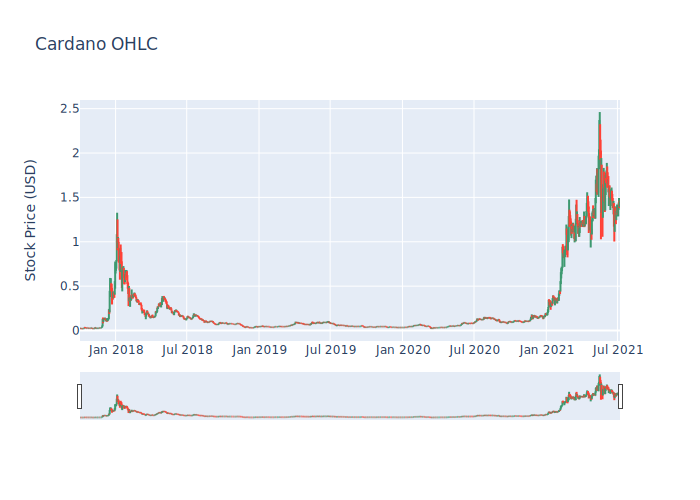

In [13]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ADA']['Date'],
                             open=df[df.Symbol == 'ADA']['Open'],
                             high=df[df.Symbol == 'ADA']['High'],
                             low=df[df.Symbol == 'ADA']['Low'],
                             close=df[df.Symbol == 'ADA']['Close']))
fig.update_layout(title='Cardano OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

## Ethereum

In [14]:
print(
    f"Min Date: {df[df.Symbol == 'ETH'].Date.min()}, Max Date: {df[df.Symbol == 'ETH'].Date.max()}"
)


Min Date: 2015-08-08 23:59:59, Max Date: 2021-07-06 23:59:59


In [15]:
df[df.Symbol == 'ETH'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2.160000e+03
mean,1080.500000,398.258568,365.592589,382.879899,383.910691,7.057058e+09,4.172084e+10
std,623.682612,628.082281,566.611523,599.719862,601.078766,1.064526e+10,6.909184e+10
min,1.000000,0.482988,0.420897,0.431589,0.434829,1.021280e+05,3.221363e+07
25%,540.750000,14.265225,13.190950,13.757600,13.819200,3.825102e+07,1.135576e+09
50%,1080.500000,205.124631,193.302715,198.425096,198.643691,2.148880e+09,2.070063e+10
75%,1620.250000,396.494561,375.146804,386.264935,386.435272,9.629136e+09,4.231010e+10
max,2160.000000,4362.350542,3785.848603,4174.635873,4168.701049,8.448291e+10,4.828819e+11


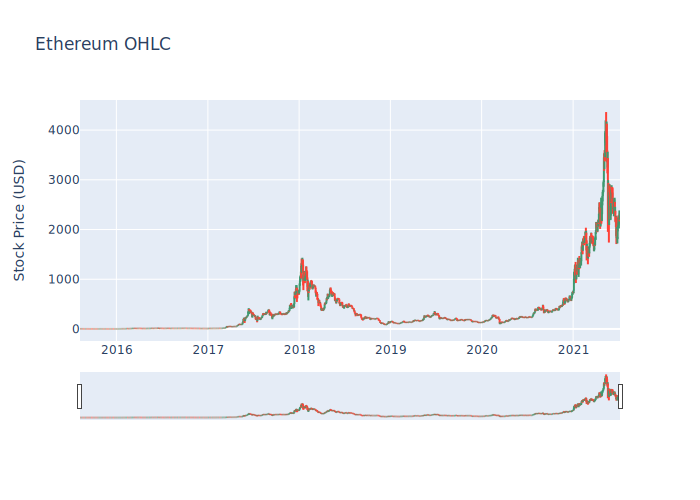

In [16]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ETH']['Date'],
                             open=df[df.Symbol == 'ETH']['Open'],
                             high=df[df.Symbol == 'ETH']['High'],
                             low=df[df.Symbol == 'ETH']['Low'],
                             close=df[df.Symbol == 'ETH']['Close']))
fig.update_layout(title='Ethereum OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

### Seasonality




<built-in method title of str object at 0x7f6e6d6bce30>


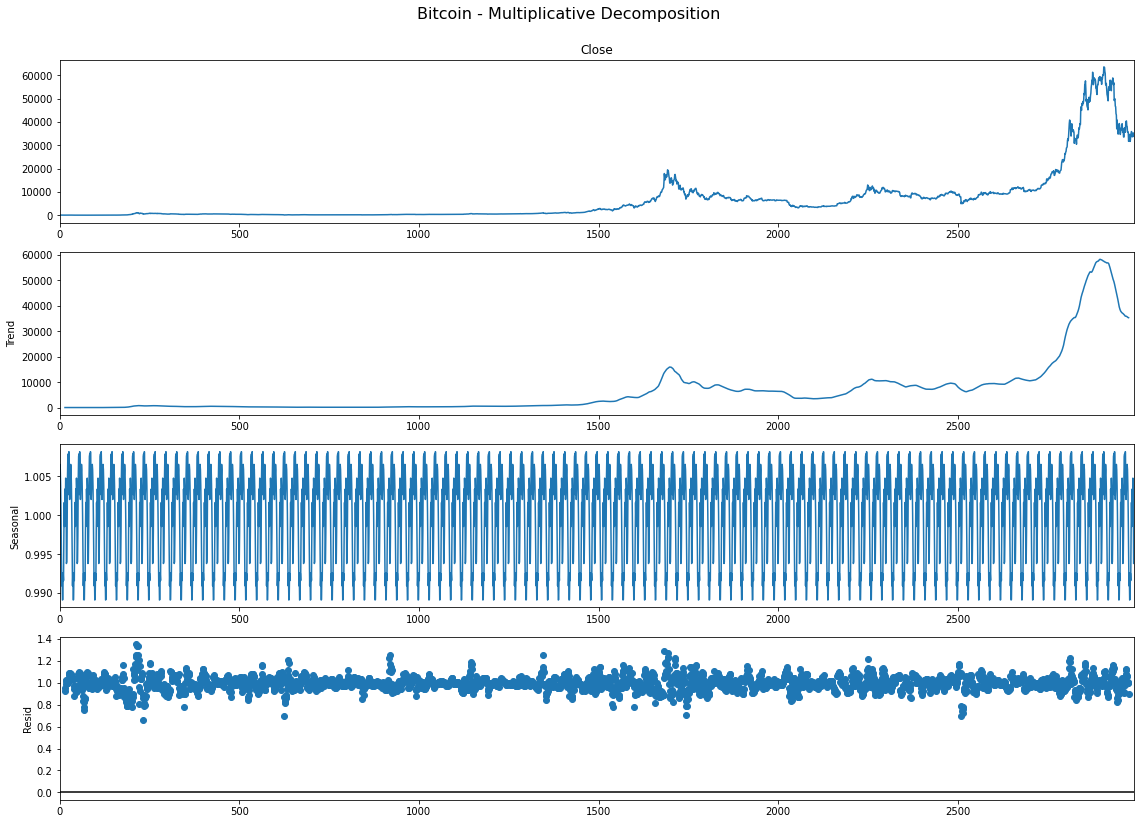

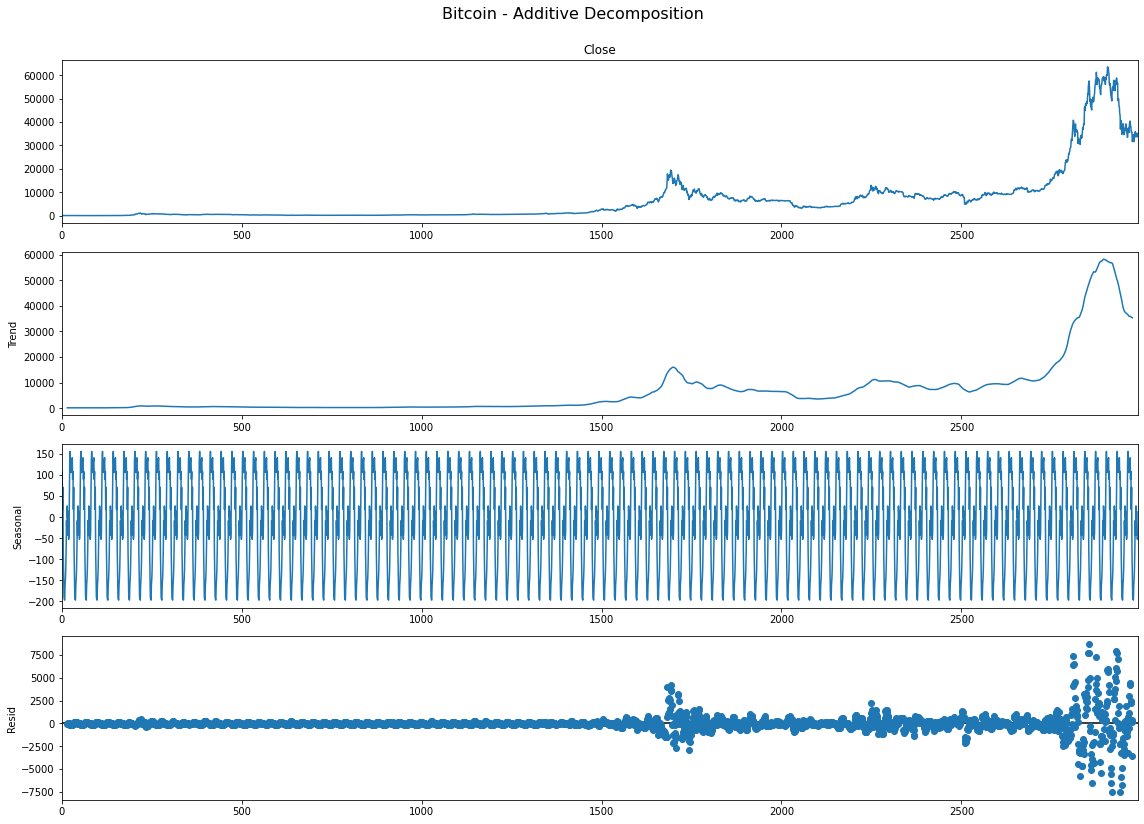




<built-in method title of str object at 0x7f6e4f7a4bf0>


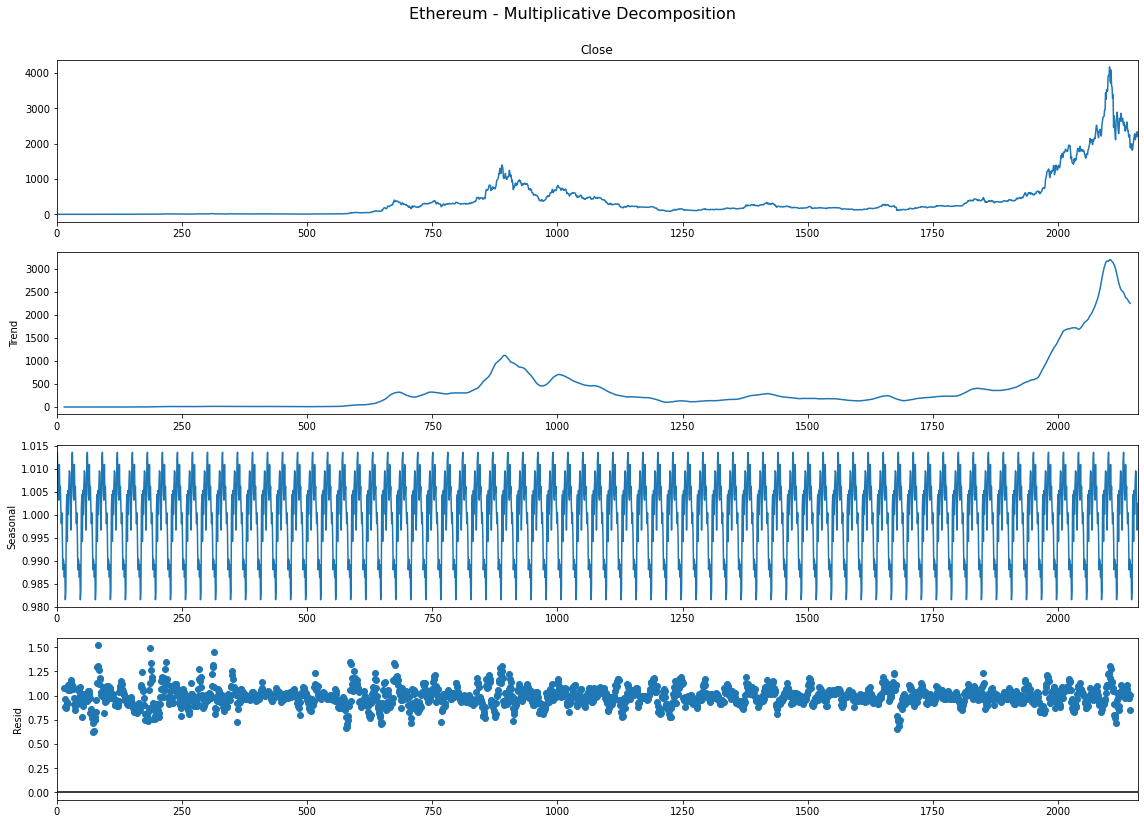

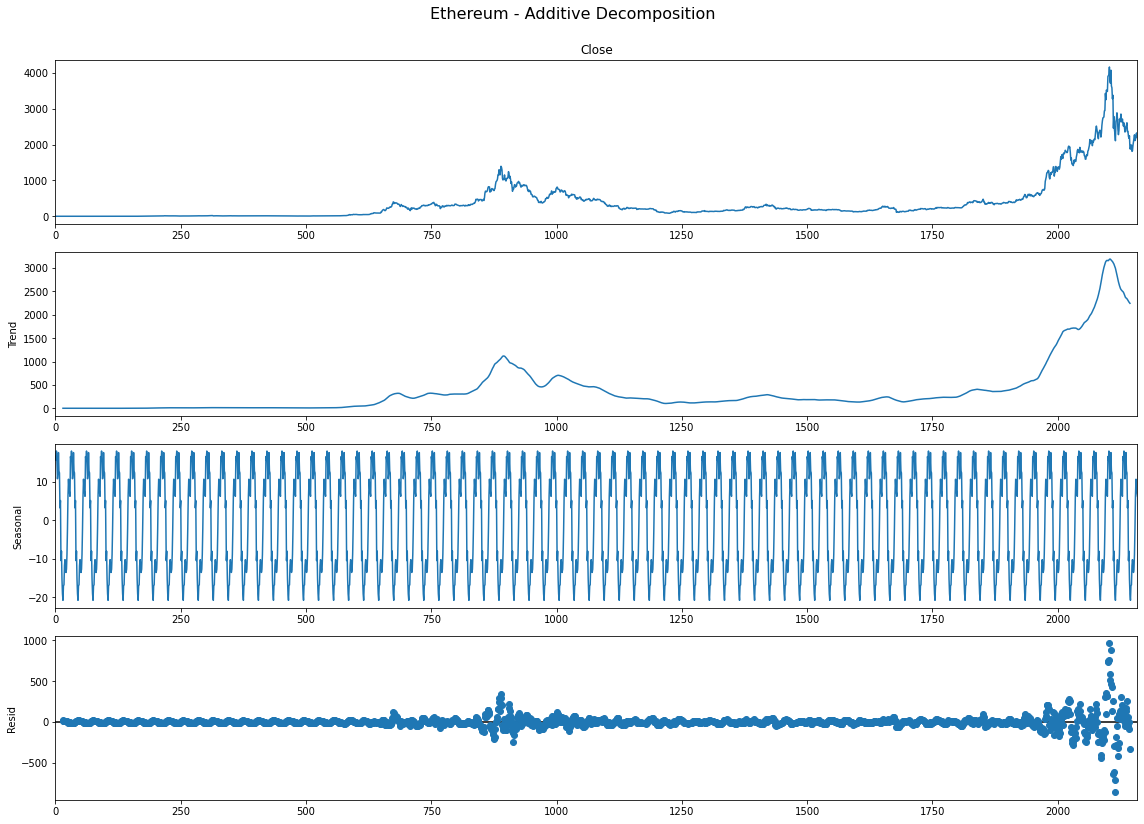




<built-in method title of str object at 0x7f6e4f7a49b0>


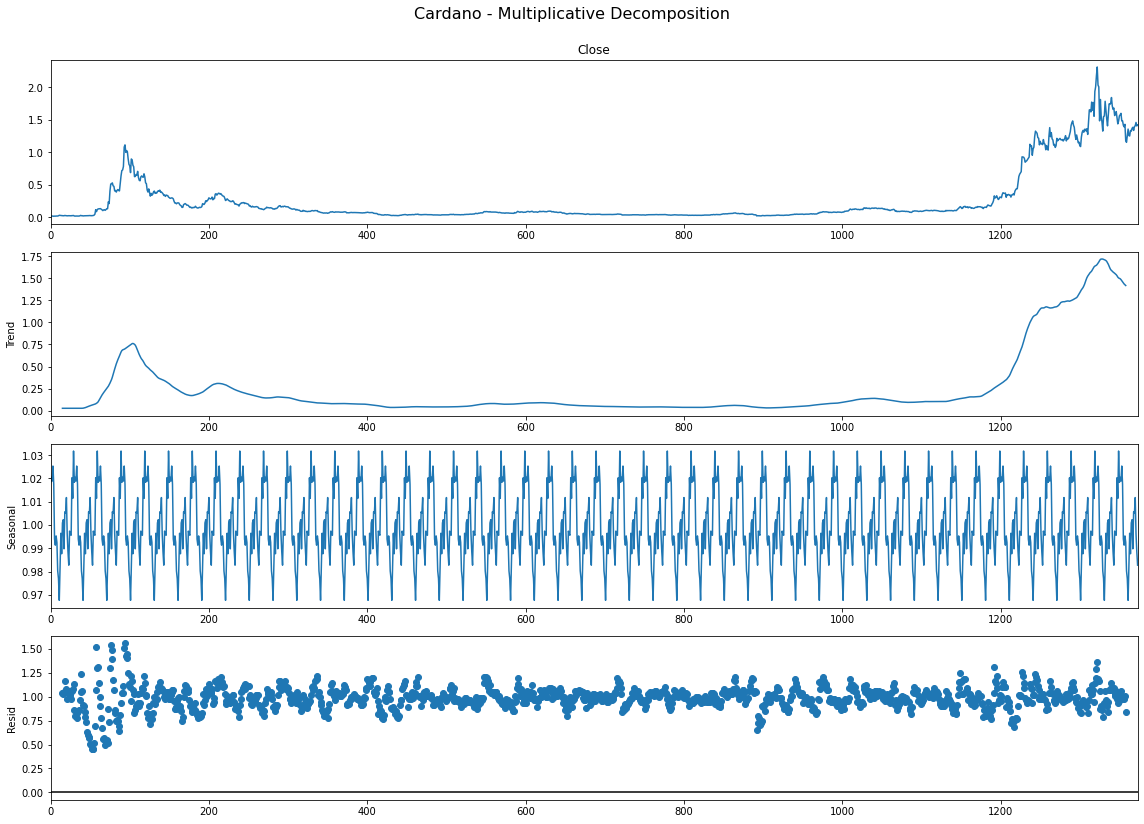

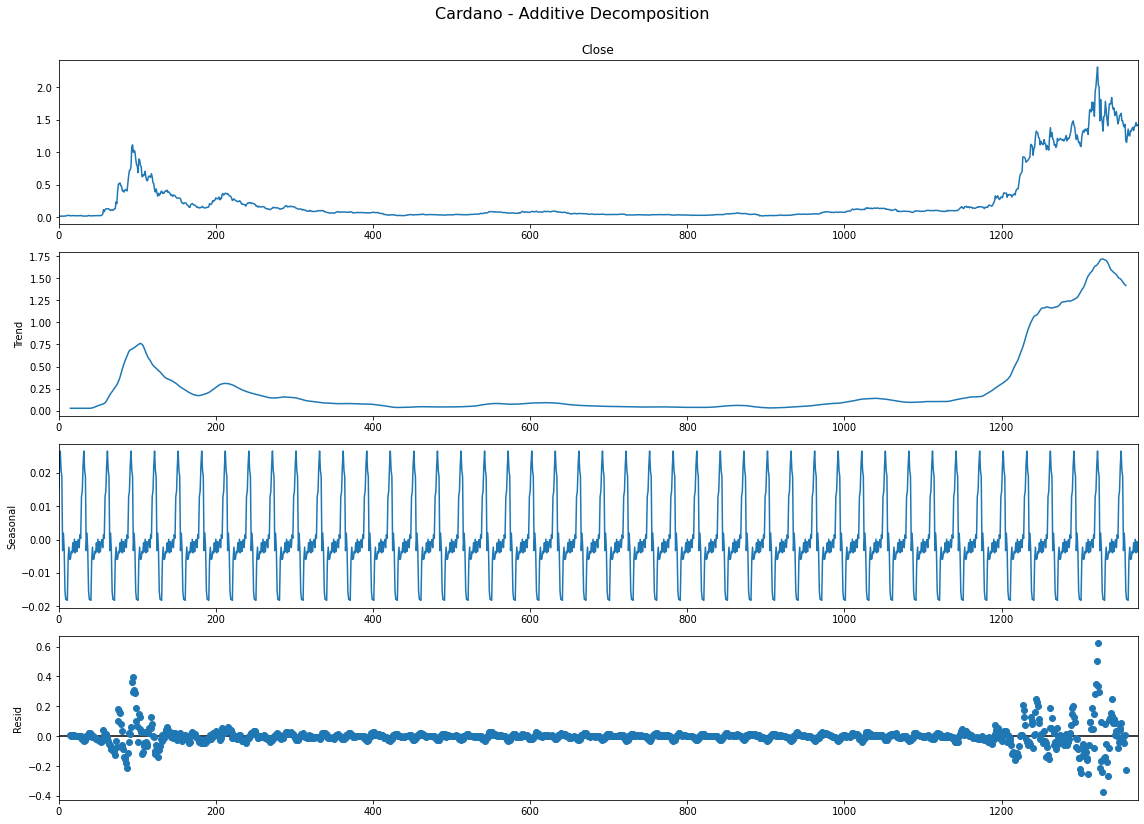

In [17]:
def plot_decompose(df: pd.DataFrame, coin: str, col):
    multiplicative_decomposition = seasonal_decompose(df[col],
                                                      model='multiplicative',
                                                      period=30)

    additive_decomposition = seasonal_decompose(df[col],
                                                model='additive',
                                                period=30)

    # Plot
    plt.rcParams.update({'figure.figsize': (16, 12)})
    multiplicative_decomposition.plot().suptitle(
        f'{coin.title()} - Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    additive_decomposition.plot().suptitle(
        f'{coin.title()} - Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


for col in coins:
    print(f'\n\n\n{col.title}')
    plot_decompose(df[df.Name == col.title()], col, 'Close')


In [18]:
df.columns

Index(['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Marketcap'],
      dtype='object')

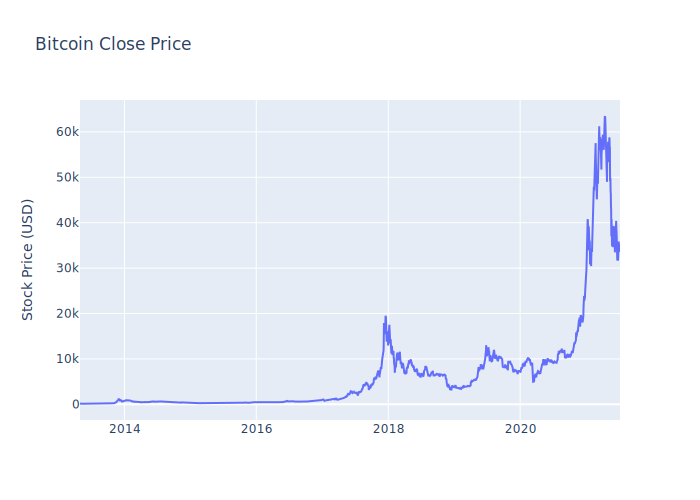

In [19]:
# create a plot to evaluate close price seasonality
fig = go.Figure(data=go.Scatter(x=df[df.Symbol == 'BTC']['Date'],
                                y=df[df.Symbol == 'BTC']['Close']))
fig.update_layout(title='Bitcoin Close Price', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")


## Train Test Split

In [31]:
processed_df = pd.read_csv('../data/processed/dataset.csv',
                           parse_dates=['date'])
processed_df.head()

,date,bitcoin_sno,bitcoin_high,bitcoin_low,bitcoin_open,bitcoin_close,bitcoin_volume,bitcoin_marketcap,ethereum_sno,ethereum_high,...,ethereum_close,ethereum_volume,ethereum_marketcap,cardano_sno,cardano_high,cardano_low,cardano_open,cardano_close,cardano_volume,cardano_marketcap
0,2013-04-29 23:59:59,1,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-30 23:59:59,2,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-01 23:59:59,3,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-02 23:59:59,4,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-03 23:59:59,5,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
date_threshold = '2021-04-01'
train = processed_df[(processed_df.date < date_threshold)
                     & (processed_df.date >= '2017-10-02')]
test = processed_df[(processed_df.date >= date_threshold)
                    & (processed_df.date >= '2017-10-02')]
print(
    f'Train: {train.shape}, Test: {test.shape}, Proportion: {train.shape[0] / (train.shape[0] + test.shape[0]):.2%}'
)

Train: (1277, 22), Test: (97, 22), Proportion: 92.94%


In [33]:
train.isna().sum()

date                  0
bitcoin_sno           0
bitcoin_high          0
bitcoin_low           0
bitcoin_open          0
bitcoin_close         0
bitcoin_volume        0
bitcoin_marketcap     0
ethereum_sno          0
ethereum_high         0
ethereum_low          0
ethereum_open         0
ethereum_close        0
ethereum_volume       0
ethereum_marketcap    0
cardano_sno           0
cardano_high          0
cardano_low           0
cardano_open          0
cardano_close         0
cardano_volume        0
cardano_marketcap     0
dtype: int64

## Feature Engineering

TODO: Test min max scaler over windows

### Columns Selection

In [34]:
class ColumnDropTransformer():

    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self


In [38]:
normalize_cols = []
for coin in coins:
    for col in ['open', 'high', 'low', 'close', 'volume', 'marketcap']:
        normalize_cols.append(f'{coin}_{col}')

drop_cols = []
for coin in coins:
    for col in ['sno']:
        drop_cols.append(f'{coin}_{col}')
drop_cols.append('date')

In [39]:
minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])

pipeline = Pipeline([
    ("column_dropper", ColumnDropTransformer(drop_cols)),
    ('normalization',
     ColumnTransformer(remainder='passthrough',
                       transformers=[('norm', minmax_transformer,
                                      normalize_cols)],
                       verbose_feature_names_out=True))
])

In [53]:
X_train = pipeline.fit_transform(train)
X_test = pipeline.transform(test)

In [54]:
feature_names = list(pipeline["normalization"].get_feature_names_out())

### Coins Correlation

In [55]:
X_train

array([[1.99972078e-02, 2.04568245e-02, 2.11394578e-02, ...,
        5.43527092e-03, 2.92064455e-03, 3.40255662e-03],
       [2.02153665e-02, 1.98103472e-02, 1.90263285e-02, ...,
        1.67387871e-03, 7.97186417e-04, 1.35492523e-03],
       [1.86789337e-02, 1.84379412e-02, 1.81625014e-02, ...,
        2.49416409e-03, 3.79336397e-04, 2.01890822e-03],
       ...,
       [9.09058410e-01, 9.42786266e-01, 9.25808233e-01, ...,
        8.70503649e-01, 1.33376464e-01, 8.70835455e-01],
       [9.40139521e-01, 9.61706935e-01, 9.63451625e-01, ...,
        8.78425991e-01, 1.31434260e-01, 8.78737498e-01],
       [9.60492161e-01, 9.69972910e-01, 9.71914637e-01, ...,
        8.63683279e-01, 1.66597919e-01, 8.64032564e-01]])

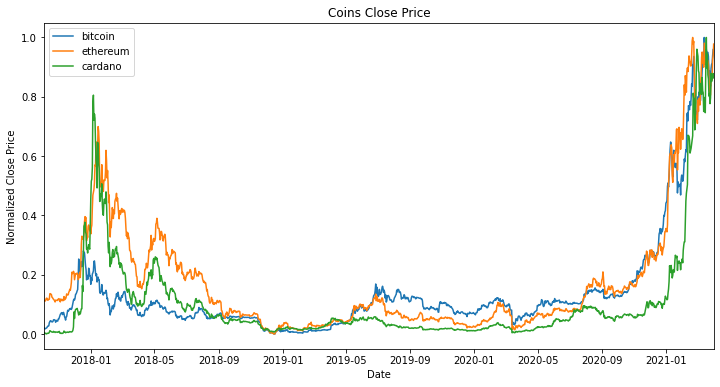

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))

for coin in coins:
    ax.plot(train["date"],
            X_train[:, feature_names.index(f'norm__{coin}_close')],
            label=coin)
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(train["date"]), max(train["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

### Correlation test

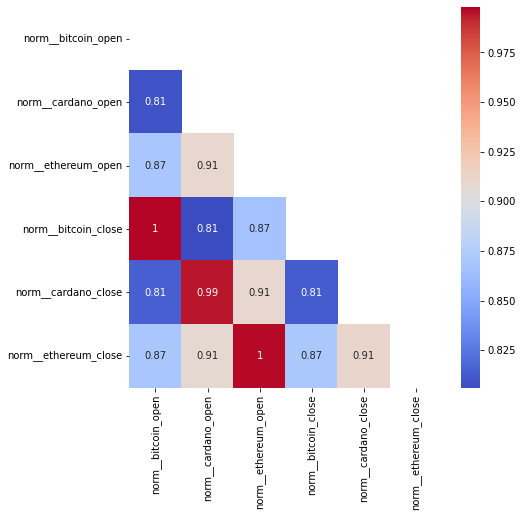

In [57]:
corr_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open',
    'norm__bitcoin_close', 'norm__cardano_close', 'norm__ethereum_close'
]
corr_cols_index = [feature_names.index(col) for col in corr_cols]
corr_dataframe = pd.DataFrame(X_train[:, corr_cols_index],
                              columns=corr_cols,
                              dtype=np.float64)
mask = np.triu(corr_dataframe.corr())
plt.figure(figsize=(7, 7))
sns.heatmap(corr_dataframe.corr(),
            mask=mask,
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm',
            annot=True)
plt.show()

### Stationary Test

In [58]:
response_string = "adf: {0:.4f}, p-value: {1:.4f}, usedlag: {2}, nobs: {3}, critical_values: {4}"

results_cols = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical values']

for col in corr_cols:
    col_index = feature_names.index(col)
    adf_results = adfuller(X_train[:, col_index])
    print(f"\n---------\n{col}\n{response_string.format(*adf_results)}")


---------
norm__bitcoin_open
adf: 3.8634, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_open
adf: -1.1591, p-value: 0.6909, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__ethereum_open
adf: 0.6970, p-value: 0.9898, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__bitcoin_close
adf: 3.8429, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_close
adf: -0.9426, p-value: 0.7736, usedlag: 23, nobs: 1253, critical_values: {'1%': -3.4355796466416777, '5%': -2.863849421064024, '10%': -2.5679995625056926}

---------
norm__ethereum_close
adf: 1.0059, p-value: 0.9943, usedlag: 

### Modeling

In [59]:
model_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open'
]
model_cols_id = [feature_names.index(col) for col in model_cols]
y_train = X_train[:, feature_names.index('norm__ethereum_close')]
X_train = X_train[:, model_cols_id]
y_test = X_test[:, feature_names.index('norm__ethereum_close')]
X_test = X_test[:, model_cols_id]

In [60]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {str(model)} MSE: {mse}, RMSE: {rmse}, r2_score: {r2}")
    return mse, rmse, r2

In [61]:
models = [
    LinearRegression(),
    Ridge(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
]
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

Model: LinearRegression() MSE: 0.010831503863275882, RMSE: 0.10407451111235586, r2_score: 0.8771141579403192
Model: Ridge() MSE: 0.011993834621607816, RMSE: 0.1095163669120183, r2_score: 0.8639272546448531
Model: RandomForestRegressor() MSE: 0.2233277143148269, RMSE: 0.47257561756276306, r2_score: -1.533703036555186
Model: GradientBoostingRegressor() MSE: 0.23123944252934714, RMSE: 0.48087362428121083, r2_score: -1.623463368643976


### Linear Regression

In [62]:
X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 6.226e+04
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:43:16   Log-Likelihood:                 3392.7
No. Observations:                1277   AIC:                            -6777.
Df Residuals:                    1273   BIC:                            -6757.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.494      0.621      -0.001       0.002
x1             0.0186      0.005      3.400      0.001       0.008       0.029
x2             0.0070      0.007      1.066      0.286      -0.006       0.020
x3             0.9827      0.007    147.645      0.000       0.970       0.996
==============================================================================
Omnibus:                      327.374   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11702.538
Skew:                          -0.452   Prob(JB):                         0.00
Kurtosis:                      17.803   Cond. No.                         19.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
model = LinearRegression()
model.fit(X_train, y_train)
linear_predictions_train = model.predict(X_train)
linear_predictions_test = model.predict(X_test)

model = Ridge()
model.fit(X_train, y_train)
ridge_predictions_train = model.predict(X_train)
ridge_predictions_test = model.predict(X_test)

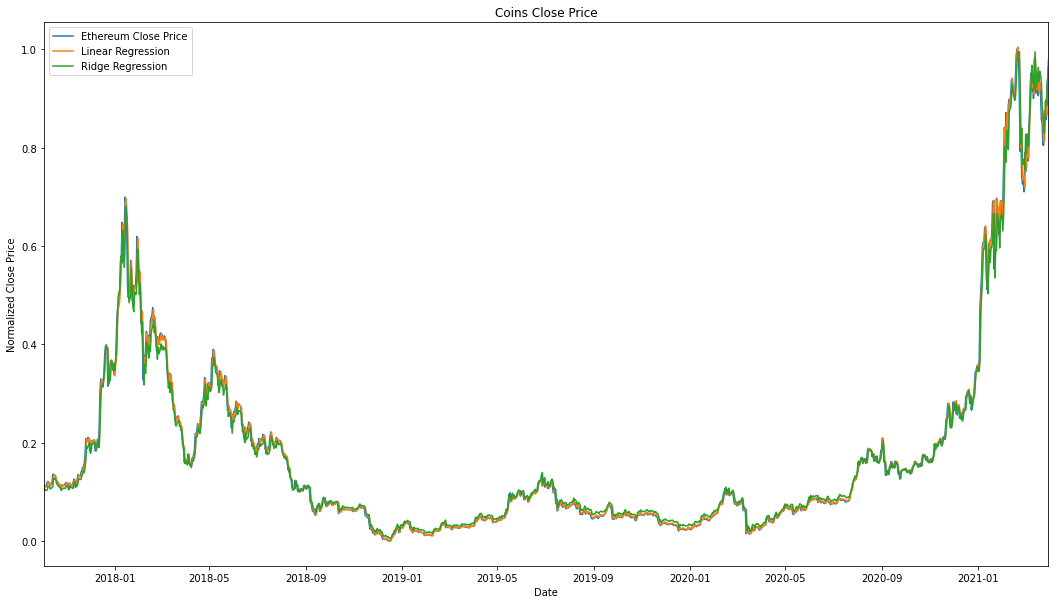

In [66]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.plot(train["date"], y_train, label="Ethereum Close Price")
ax.plot(train["date"], linear_predictions_train, label="Linear Regression")
ax.plot(train["date"], ridge_predictions_train, label="Ridge Regression")
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(train["date"]), max(train["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

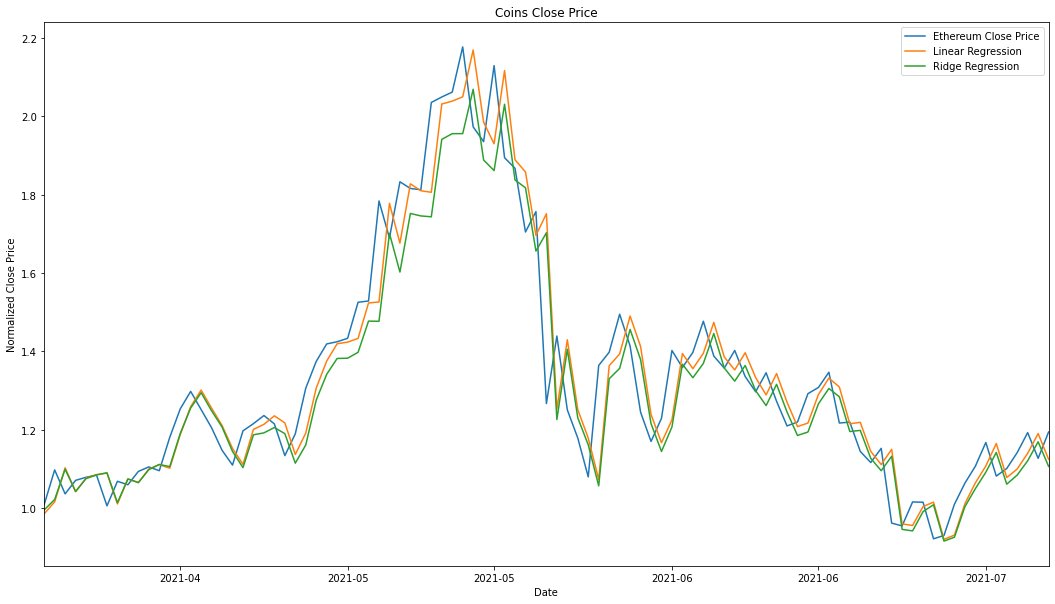

In [71]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.plot(test["date"], y_test, label="Ethereum Close Price")
ax.plot(test["date"], linear_predictions_test, label="Linear Regression")
ax.plot(test["date"], ridge_predictions_test, label="Ridge Regression")
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(test["date"]), max(test["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

## Trend Prediciton (Classification)

In [75]:
y_train_trend = [
    train["ethereum_close"].iloc[i] > train["ethereum_open"].iloc[i]
    for i in range(train.shape[0])
]
y_test_trend = [
    test["ethereum_close"].iloc[i] > test["ethereum_open"].iloc[i]
    for i in range(test.shape[0])
]


In [81]:
def evaluate_class_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(
        f"Model: {str(model)} Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}"
    )


In [94]:
class_models = [
    LogisticRegression(penalty="none", random_state=42),
    LogisticRegression(penalty="l2", random_state=42),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: LogisticRegression(penalty='none', random_state=42) Precision: 0.625, Recall: 0.2631578947368421, F1: 0.37037037037037035, Accuracy: 0.4742268041237113
Model: LogisticRegression(random_state=42) Precision: 0.7142857142857143, Recall: 0.5263157894736842, F1: 0.6060606060606061, Accuracy: 0.5979381443298969
Model: RandomForestClassifier(random_state=42) Precision: 0.5, Recall: 0.03508771929824561, F1: 0.06557377049180328, Accuracy: 0.41237113402061853
Model: GradientBoostingClassifier(random_state=42) Precision: 1.0, Recall: 0.03508771929824561, F1: 0.06779661016949151, Accuracy: 0.4329896907216495


In [95]:
class_models = [DummyClassifier(), DummyClassifier(strategy='uniform')]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: DummyClassifier() Precision: 0.5876288659793815, Recall: 1.0, F1: 0.7402597402597402, Accuracy: 0.5876288659793815
Model: DummyClassifier(strategy='uniform') Precision: 0.6888888888888889, Recall: 0.543859649122807, F1: 0.6078431372549019, Accuracy: 0.5876288659793815
